# Предсказание оттока пользователей

Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

In [216]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Первая часть. Исследование

## Загрузка данных

Загружаем обучающую и тестовые выборки в   `train` и `test` соответственно

In [279]:
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

Посмотрим на случайные объекты в тестовой выборке

In [218]:
train.sample(10, random_state=42)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
1942,39,50.75,2011.4,Female,0,No,No,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1859,52,79.20,4016.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
2348,1,74.40,74.4,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2280,6,50.80,288.05,Female,0,No,No,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),1
733,21,68.65,1493.2,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0


In [219]:
train.shape

(5282, 20)

In [220]:
train.dtypes  # Можно заметить, что TotalSpent - object, хотя это должен быть float. Значит, там проблемы с форматом данных или есть пропуски

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [221]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [222]:
len(num_cols), len(cat_cols)

(3, 16)

Обучающая выборка состоит из 5282 объектов, имеем 19 признаков (3 числовых и 16 категориальных), целевая переменная **Churn** - уйдет ли от нас клиент

Посмотрим на возможные значения категориальных признаков:

In [223]:
for i, cat in enumerate(cat_cols):
    unique_cat = train[cat].unique()
    print(f"{i+1}) {cat} ({len(unique_cat)}): {unique_cat}")

1) Sex (2): ['Male' 'Female']
2) IsSeniorCitizen (2): [0 1]
3) HasPartner (2): ['Yes' 'No']
4) HasChild (2): ['Yes' 'No']
5) HasPhoneService (2): ['Yes' 'No']
6) HasMultiplePhoneNumbers (3): ['No' 'Yes' 'No phone service']
7) HasInternetService (3): ['No' 'Fiber optic' 'DSL']
8) HasOnlineSecurityService (3): ['No internet service' 'No' 'Yes']
9) HasOnlineBackup (3): ['No internet service' 'No' 'Yes']
10) HasDeviceProtection (3): ['No internet service' 'No' 'Yes']
11) HasTechSupportAccess (3): ['No internet service' 'Yes' 'No']
12) HasOnlineTV (3): ['No internet service' 'No' 'Yes']
13) HasMovieSubscription (3): ['No internet service' 'No' 'Yes']
14) HasContractPhone (3): ['One year' 'Two year' 'Month-to-month']
15) IsBillingPaperless (2): ['No' 'Yes']
16) PaymentMethod (4): ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


В данных нет пропусков

In [224]:
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Однако мы заметили проблему с типом TotalSpent. Рассмотрим этот признак                  

In [225]:
print(np.sort(train['TotalSpent'].unique()))
train['TotalSpent'].value_counts()

[' ' '100.2' '100.25' ... '997.65' '998.1' '999.9']


           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

Мы видим пробелы (`_`) в признаке. Выведем объекты с пробелами (их оказалось 9)

In [226]:
train[train['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [227]:
train[train['TotalSpent'] == ' '].shape

(9, 20)

Можно заметить, что у данных объектов также ClientPeriod = 0 (видимо, клиенты еще не зарегистрированы). 

Посмотрим также на объекты с ClientPeriod = 0

In [228]:
print(np.sort(train['ClientPeriod'].unique()))
train['ClientPeriod'].value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


1     457
72    284
2     165
3     162
4     136
     ... 
57     39
39     35
44     34
36     34
0       9
Name: ClientPeriod, Length: 73, dtype: int64

In [229]:
train[train['ClientPeriod'] == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [230]:
train[train['ClientPeriod'] == 0].shape

(9, 20)

Как можно заметить, объекты с TotalSpent = ' ' и ClientPeriod = 0 - одни и те же. Проверим это напрямую:

In [231]:
((train['TotalSpent'] == ' ') == (train['ClientPeriod'] == 0)).all()

True

Да, это действительно так. По всей видимости, это какая-то недоработка в системе сбора данных. Позволим себе удалить такие объекты из выборки

In [232]:
train.drop(train[train['TotalSpent'] == ' '].index, axis='index', inplace=True)
train.reset_index(drop=True, inplace=True)
train['TotalSpent'] = train['TotalSpent'].astype(float)
train

# train.replace(' ', 0, inplace=True)
# train['TotalSpent'] = train['TotalSpent'].astype(float)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5269,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5270,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5271,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


Проделаем те же операции с тестовой выборкой

In [233]:
test.sample(5, random_state=42)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
966,13,74.65,966.25,Female,0,No,No,Yes,No,Fiber optic,No,Yes,No,No,No,No,One year,Yes,Mailed check
1524,69,80.65,5542.55,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,No,Yes,Yes,Yes,Two year,No,Bank transfer (automatic)
1580,1,69.95,69.95,Male,0,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
816,62,84.45,4959.15,Female,1,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,One year,No,Electronic check
1026,25,69.30,1813.1,Female,1,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [234]:
test.shape

(1761, 19)

In [235]:
test.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
dtype: object

In [236]:
for i, cat in enumerate(cat_cols):
    unique_cat = test[cat].unique()
    print(f"{i+1}) {cat} ({len(unique_cat)}): {unique_cat}")

1) Sex (2): ['Male' 'Female']
2) IsSeniorCitizen (2): [0 1]
3) HasPartner (2): ['Yes' 'No']
4) HasChild (2): ['No' 'Yes']
5) HasPhoneService (2): ['Yes' 'No']
6) HasMultiplePhoneNumbers (3): ['Yes' 'No' 'No phone service']
7) HasInternetService (3): ['DSL' 'Fiber optic' 'No']
8) HasOnlineSecurityService (3): ['Yes' 'No' 'No internet service']
9) HasOnlineBackup (3): ['No' 'Yes' 'No internet service']
10) HasDeviceProtection (3): ['No' 'Yes' 'No internet service']
11) HasTechSupportAccess (3): ['No' 'Yes' 'No internet service']
12) HasOnlineTV (3): ['No' 'Yes' 'No internet service']
13) HasMovieSubscription (3): ['No' 'Yes' 'No internet service']
14) HasContractPhone (3): ['One year' 'Month-to-month' 'Two year']
15) IsBillingPaperless (2): ['No' 'Yes']
16) PaymentMethod (4): ['Credit card (automatic)' 'Electronic check' 'Bank transfer (automatic)'
 'Mailed check']


In [237]:
test.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

In [238]:
print(np.sort(test['TotalSpent'].unique()))
print(test['TotalSpent'].value_counts())

[' ' '100.8' '1001.2' ... '997.75' '999.45' '999.8']
19.55      4
20.25      4
45.3       3
19.9       3
2440.25    2
          ..
4138.9     1
3522.65    1
101.45     1
1794.65    1
4566.5     1
Name: TotalSpent, Length: 1710, dtype: int64


In [239]:
test[test['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [240]:
test[test['ClientPeriod'] == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [241]:

print(((test['TotalSpent'] == ' ') == (test['ClientPeriod'] == 0)).all())

True


In [281]:
# test.drop(test[test['TotalSpent'] ==  ' '].index, axis='index', inplace=True)
# test.reset_index(drop=True, inplace=True)
# test['TotalSpent'] = test['TotalSpent'].astype(float)
# test

test.replace(' ', 0, inplace=True)
test['TotalSpent'] = test['TotalSpent'].astype(float)

Мы загрузили данные test и train и обработали пропуски. Перейдем к анализу данных

## Анализ данных

Целевая переменная - Churn, 1 - клиент ушел (gone), 0 - клиент остался (stayed)

In [243]:
gone = train[train[target_col] == 1]
stayed = train[train[target_col] == 0]

Рассмотрим числовых признаки

In [244]:
print(num_cols)  # численные признаки

['ClientPeriod', 'MonthlySpending', 'TotalSpent']


In [245]:
gone[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,1384.000000,1384.000000,1384.000000
mean,17.951590,74.281178,1525.831864
std,19.460135,24.551353,1881.443058
min,1.000000,18.950000,19.100000
25%,2.000000,56.437500,134.650000
50%,10.000000,79.500000,706.725000
75%,29.000000,94.200000,2352.550000
max,72.000000,118.350000,8684.800000


In [246]:
stayed[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,3889.000000,3889.000000,3889.000000
mean,37.612754,61.638442,2563.834045
std,24.083920,31.281198,2332.182253
min,1.000000,18.250000,18.800000
25%,15.000000,25.100000,568.200000
50%,37.000000,64.800000,1714.550000
75%,61.000000,89.150000,4284.200000
max,72.000000,118.750000,8672.450000


Построим гистограммы для числовых признаков (относительные частоты встречи значений признаков для gone и stayed)

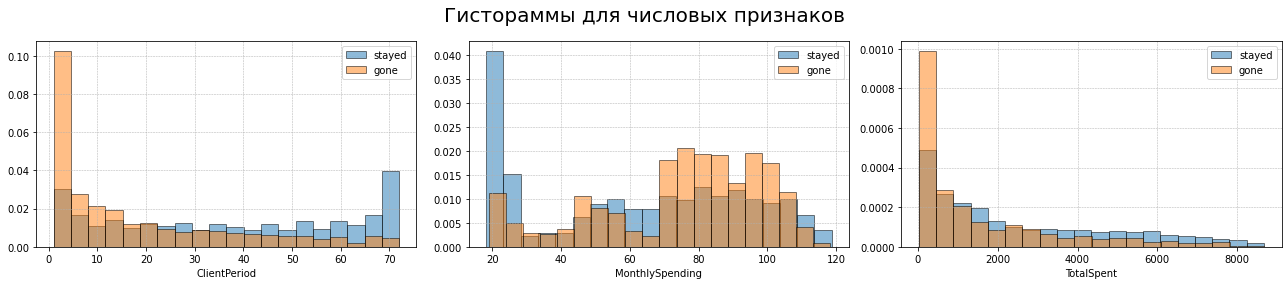

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.suptitle('Гистораммы для числовых признаков', fontsize=20)
for i, col in enumerate(num_cols):
    ax[i].hist(x=stayed[col], density=True, bins=20, alpha=0.5, label='stayed', edgecolor='k')
    ax[i].hist(x=gone[col], density=True, bins=20, alpha=0.5, label='gone', edgecolor='k')
    ax[i].set(xlabel=col)
    ax[i].legend()
    ax[i].grid(ls='--', lw=0.5)

fig.tight_layout()


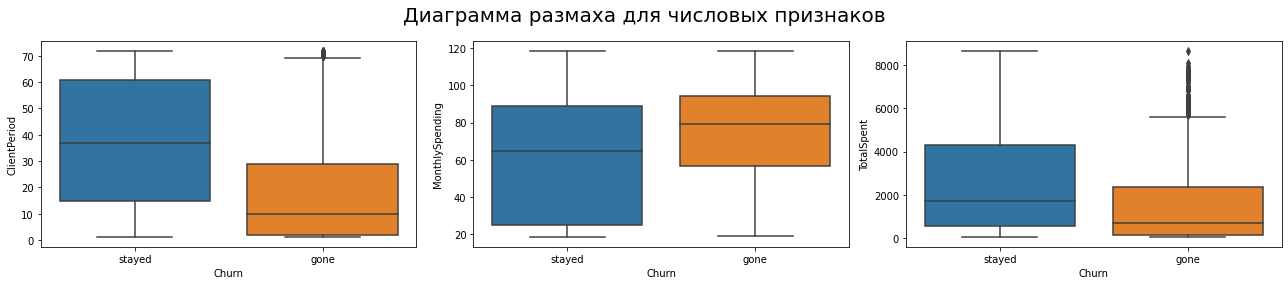

In [248]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.suptitle('Диаграмма размаха для числовых признаков', fontsize=20)
for i, col in enumerate(num_cols):
    sns.boxplot(data=train, x='Churn', y=col, ax=ax[i])
    ax[i].set_xticklabels(['stayed', 'gone'])
    
    
fig.tight_layout()


Рассмотрим категориальные признаки

In [249]:
print(cat_cols)

['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


In [250]:
# for i, cat in enumerate(cat_cols):
#     print(stayed[cat].value_counts())

In [251]:
# for i, cat in enumerate(cat_cols):
#     print(gone[cat].value_counts())

Построим круговые диаграммы

Две соседние диаграммы в каждой строке показывают частоты встречи данной категории для оставшихся и ушедших клиентов

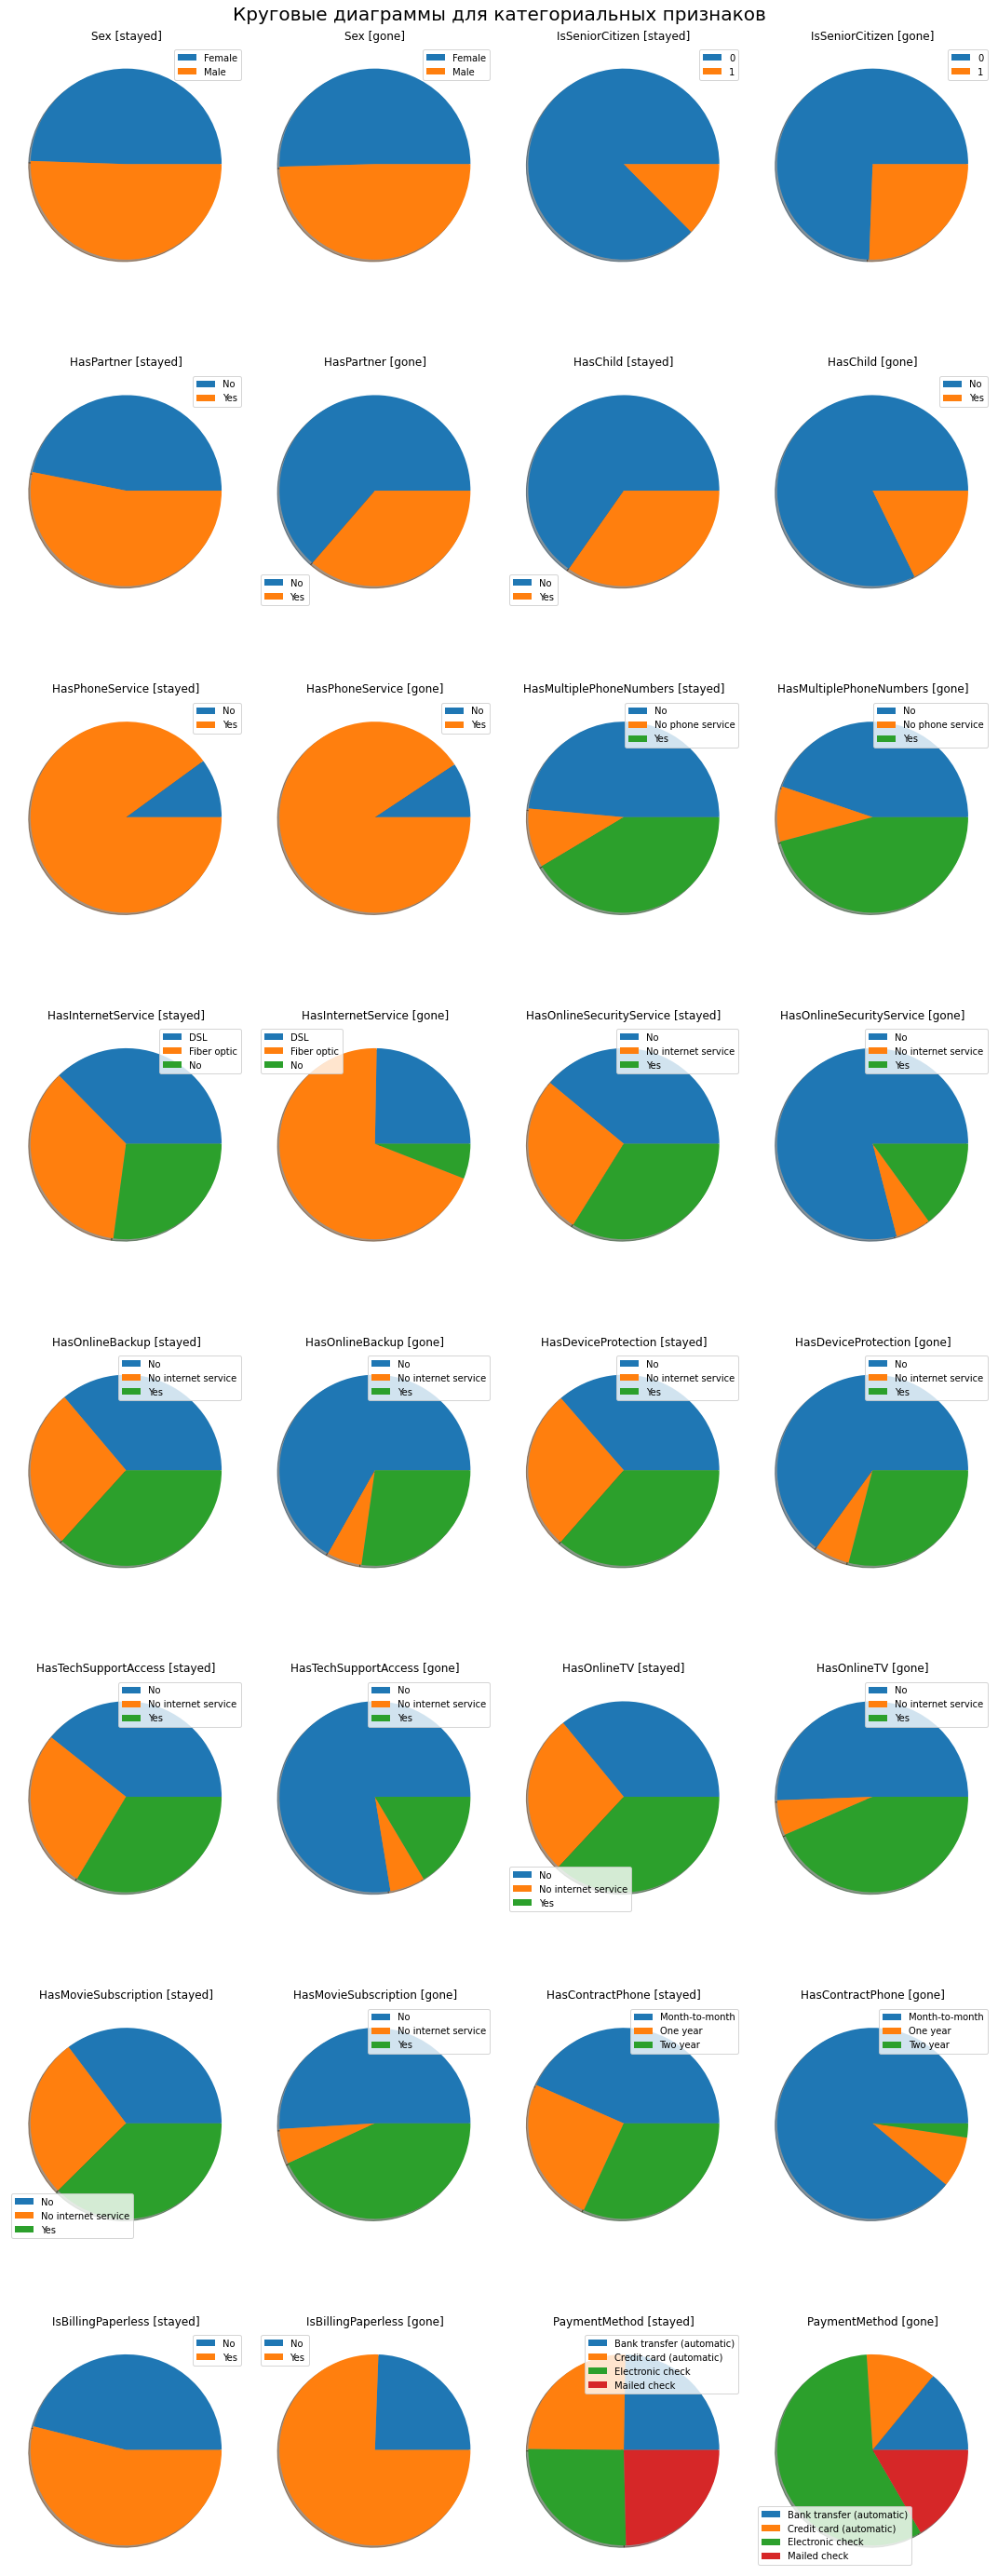

In [252]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(15, 40))
ax = ax.reshape(-1)
fig.suptitle('Круговые диаграммы для категориальных признаков', fontsize=20)
for i, cat in enumerate(cat_cols):
    idx = 2*i
    
    xs = stayed[cat].value_counts().sort_index()  # сортировка по индексам для одинаковых цветов категорий
    index_s = xs.index
    ax[idx].pie(x=xs, shadow=True)
    ax[idx].set_title(cat + " [stayed]")
    ax[idx].legend(index_s) 
    
    xg = gone[cat].value_counts().sort_index()
    index_g = xg.index
    ax[idx+1].pie(x=xg, shadow=True)
    ax[idx+1].set_title(cat + " [gone]")
    ax[idx+1].legend(index_g)

fig.tight_layout()

Рассмотрим распределение классов целевой переменной:

In [253]:
xt = train[target_col].value_counts()
xt

0    3889
1    1384
Name: Churn, dtype: int64

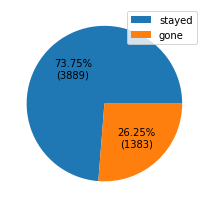

In [254]:
fig, ax = plt.subplots(figsize=(3, 4))
ax.pie(x=xt, autopct=lambda x: f"{x:.2f}%\n({int(xt.sum()*x/100)})")
ax.legend(["stayed", "gone"])
fig.tight_layout()

Как мы видим, в выборке есть небольшой дисбаланс классов, так что метрика accuracy нам не подходит. Однако количивество объектов обоих классов одного порядка, так что выборку нельзя назвать сильно несбалансированной

## Применение линейных моделей

In [255]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve

Разделим обучающую выборку на признаки и ответы:

In [282]:
X_train = train[feature_cols]
y_train = train[target_col]

X_test = test[feature_cols]


Полготовим преобразование One-Hot encoding для категориальных признаков и RobustScaler для числовыз признаков (у нас есть значительное число значений с большими отклонениями, так что RobustScaler нам особенно подходит)

In [257]:
col_transformer = ColumnTransformer([
    ('cat_cols', OneHotEncoder(drop='first'), cat_cols),
    ('num_cols', RobustScaler(), num_cols)
])  # числовые признаки пока не нормируем, будем делать это в pipeline'е при CV, чтобы избежать утечки данных

Приготовим pipeline для CV логистической регресии для подбора гиперпараметров

In [258]:
cls_logreg_pipeline = Pipeline([
    ('num_cols_preprocessing', col_transformer),
    ("logreg", LogisticRegression(solver='saga', random_state=42, max_iter=1000))
])

Сетка гиперпараметров для CV

In [259]:
cls_logreg_param_grid = {
    'logreg__penalty': ['none', 'l1', 'l2'],
    'logreg__C': [1e6, 1e5, 1e4, 1e3, 100, 10, 1, 0.1, 0.01],
    'logreg__fit_intercept': [True, False],
}

cls_logreg_elasticnet_param_grid = {
    'logreg__penalty': ['elasticnet'],
    'logreg__l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.99],
    'logreg__C': [1e6, 1e5, 1e4, 1e3, 100, 10, 1, 0.1, 0.01],
    'logreg__fit_intercept': [True, False],
}

Проведем подбор лучших гиперпараметров для логистической регресии

In [260]:
grid_search_logreg_cls = GridSearchCV(estimator=cls_logreg_pipeline,
                                      param_grid=cls_logreg_param_grid, 
                                      scoring='roc_auc', 
                                      verbose=0, 
                                      n_jobs=-1, 
                                      cv=3, 
                                      refit=True)

In [261]:
grid_search_logreg_elasticnet_cls = GridSearchCV(estimator=cls_logreg_pipeline,
                                      param_grid=cls_logreg_elasticnet_param_grid, 
                                      scoring='roc_auc', 
                                      verbose=0, 
                                      n_jobs=-1, 
                                      cv=3, 
                                      refit=True)

In [262]:
grid_search_logreg_cls.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('num_cols_preprocessing',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecuri

In [263]:
grid_search_logreg_elasticnet_cls.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('num_cols_preprocessing',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecuri

Лучшие параметры

In [264]:
print(grid_search_logreg_cls.best_params_)
print(grid_search_logreg_elasticnet_cls.best_params_)

{'logreg__C': 1000.0, 'logreg__fit_intercept': False, 'logreg__penalty': 'l2'}
{'logreg__C': 1000.0, 'logreg__fit_intercept': False, 'logreg__l1_ratio': 0.01, 'logreg__penalty': 'elasticnet'}


Величина ROC AUC для лучших параметров

In [265]:
print(grid_search_logreg_cls.best_score_)  # none, l1 или l2
print(grid_search_logreg_elasticnet_cls.best_score_)  # elasticnet

0.8429842548780129
0.8429853698599697


Выберем лучшую регуляризацию

In [266]:
if grid_search_logreg_cls.best_score_ > grid_search_logreg_elasticnet_cls.best_score_:
    grid_search_logreg_cls_best = grid_search_logreg_cls
else:
    grid_search_logreg_cls_best = grid_search_logreg_elasticnet_cls

Теперь предскажем ответы на тестовой выборке

In [267]:
logreg_cls = grid_search_logreg_cls_best.predict_proba(X_test)
logreg_cls

array([[0.96298475, 0.03701525],
       [0.26406369, 0.73593631],
       [0.31732308, 0.68267692],
       ...,
       [0.24943178, 0.75056822],
       [0.35580683, 0.64419317],
       [0.99025289, 0.00974711]])

## Градиентный бустинг

### Catboost

Важно, что при работе с catboost не надо заниматься предобработкой категориальных признаков

In [268]:
from catboost import Pool, CatBoostClassifier

Проведем подбор гипербараметров при помощи CV (здесь Hold-Out)

In [269]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train.values, train_size=0.8, random_state=42)

In [270]:
train_catboost = Pool(data=X_train_cv,
                      label=y_train_cv,
                      cat_features=cat_cols,
                      feature_names=feature_cols,
                      thread_count=-1
                      )

In [271]:
cls_catboost = CatBoostClassifier(random_state=42, verbose=False, cat_features=cat_cols, bootstrap_type = 'Bayesian')

Построим сетку для отбора гиперпараметров

In [272]:
param_grid_catboost = {
    "num_trees": [50, 100, 200, 300, 500],
    "learning_rate":[0.03, 0.05],
    "max_depth": [2, 4, 6, 8], #2,4,6,8
    "grow_policy":['Lossguide'],#как будет применяться жадный алгоритм поиска
    "min_data_in_leaf":[10, 25, 50, 100], 
    "score_function": ['L2']
    
}

# param_grid_catboost = {
#     "num_trees": [300],
#     "learning_rate":[0.01, 0.05],
#     "max_depth": [4, 6], #2,4,6,8
#     "grow_policy":['Lossguide'],#как будет применяться жадный алгоритм поиска
#     "min_data_in_leaf":[100], 
#     "score_function": ['L2']
    
# }

In [273]:
grid_search_catboost = cls_catboost.grid_search(param_grid=param_grid_catboost,
                                                X=train_catboost,
                                                refit=True)


bestTest = 0.4466520053
bestIteration = 49

0:	loss: 0.4466520	best: 0.4466520 (0)	total: 240ms	remaining: 38.1s

bestTest = 0.4279530909
bestIteration = 49

1:	loss: 0.4279531	best: 0.4279531 (1)	total: 449ms	remaining: 35.4s

bestTest = 0.4242997577
bestIteration = 99

2:	loss: 0.4242998	best: 0.4242998 (2)	total: 876ms	remaining: 45.8s

bestTest = 0.4133120092
bestIteration = 99

3:	loss: 0.4133120	best: 0.4133120 (3)	total: 1.3s	remaining: 50.7s

bestTest = 0.412686701
bestIteration = 199

4:	loss: 0.4126867	best: 0.4126867 (4)	total: 2.15s	remaining: 1m 6s

bestTest = 0.4078108656
bestIteration = 195

5:	loss: 0.4078109	best: 0.4078109 (5)	total: 3.01s	remaining: 1m 17s

bestTest = 0.4094771348
bestIteration = 299

6:	loss: 0.4094771	best: 0.4078109 (5)	total: 4.25s	remaining: 1m 32s

bestTest = 0.4072980552
bestIteration = 267

7:	loss: 0.4072981	best: 0.4072981 (7)	total: 5.64s	remaining: 1m 47s

bestTest = 0.4069832403
bestIteration = 497

8:	loss: 0.4069832	best: 0.4069832 (8

Лучшие гиперпараметры

In [274]:
grid_search_catboost['params']

{'min_data_in_leaf': 50,
 'depth': 2,
 'iterations': 500,
 'learning_rate': 0.05,
 'grow_policy': 'Lossguide',
 'score_function': 'L2'}

In [275]:
cls_catboost_best = CatBoostClassifier(cat_features=cat_cols,  random_state=42, verbose=False, bootstrap_type = 'Bayesian', **grid_search_catboost['params'])
cls_catboost_best.fit(X_train_cv, y_train_cv)

In [276]:
y_train_cv_predicted = cls_catboost_best.predict_proba(X_train_cv)[:, 1]
y_test_cv_predicted = cls_catboost_best.predict_proba(X_test_cv)[:, 1]

catboost_roc_auc_train = roc_auc_score(y_train_cv, y_train_cv_predicted)
catboost_roc_auc_test = roc_auc_score(y_test_cv, y_test_cv_predicted)
print(f"ROC-AUC train: {catboost_roc_auc_train}\nROC-AUC test: {catboost_roc_auc_test}")

ROC-AUC train: 0.8640187734827592
ROC-AUC test: 0.8479759377211606


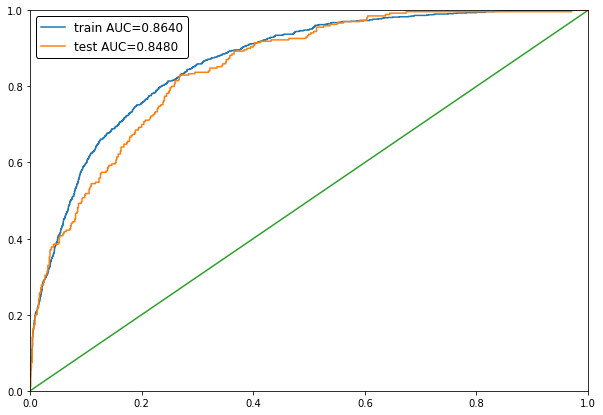

In [277]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_cv, y_train_cv_predicted)[:2], label='train AUC={:.4f}'.format(catboost_roc_auc_train))
plt.plot(*roc_curve(y_test_cv, y_test_cv_predicted)[:2], label='test AUC={:.4f}'.format(catboost_roc_auc_test))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Итог

В ходе работы наилучший результат по метрике ROC-AUC был получен с использованием градиентного бустинга из библиотеки catboost. Отправим ответы на тестовой выборке, полученные моелью catboost, обученной для лучших гиперпараметров

In [286]:
submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = cls_catboost_best.predict_proba(X_test)[:, 1]
submission.head()
submission.to_csv('result.csv', index=False)